# Chapter 8 - Trees

# 7 In the lab, we applied random forests to the Boston data using mtry=6 and using ntree=25 and ntree=500. Create a plot displaying the test error resulting from random forests on this data set for a more comprehensive range of values for mtry and ntree. You can model your plot after Figure 8.10. Describe the results obtained

In [2]:
import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import HTML
from ipywidgets import interact
import ipywidgets as widgets
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
import graphviz 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier

In [316]:
Boston = datasets.load_boston()

In [317]:
#    ALTERNATIVE APPROACH
#Boston_df = pd.DataFrame( data=np.c_[Boston['data'], Boston['target']], 
 #       columns= [c for c in Boston['feature_names']] + ['Price'])
Boston_df = pd.DataFrame(data= Boston.data, columns = Boston.feature_names)
Boston_df['Target'] = Boston.target

In [318]:
Boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [319]:
from sklearn.model_selection import train_test_split
X = Boston_df.drop('Target',axis=1)
y= Boston_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [321]:
# Compare test RMSE of Random Forest for various numbers of features considered at each split (mtry)
# and increasing number of trees (ntree)
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

max_feature = {'p': X.shape[1], # Normal Decision Tree
                'p/2': int(np.around(X.shape[1]/2)), # Half of the features 
                '$\sqrt{p}$': int(np.around(np.sqrt(X.shape[1]))), # Sqrt of the features
                '1': 1} # only one feature - one leaf tree


results = []
for mtry in max_feature:    
    for i in np.arange(1,20):
        RandomForest    = RandomForestRegressor(max_features= max_feature.get(mtry),random_state=42,n_estimators=i)
        RandomForest.fit(X_train,y_train)
        pred = RandomForest.predict(X_test)
        mse = metrics.mean_squared_error(pred, y_test)
        rmse = np.sqrt(mse)
        results += [[i,mtry,rmse]]



The above shows the test RMSE for a 50% holdout set where training set contains 240 observations each with 14 predictors. 
 We find that the test RMSE decreases with increasing number of trees for all values of mtry (number of random features considered at each split) 
 The optimal value of m is less than p and greater than 1. In this case m=p‾√ yields the best results for ntree>? although p/2 performs better for some lower tree counts. 
 Incredibly the model does not seem prone to overfitting with test RMSE continuing to decrees up to ntree = 100.


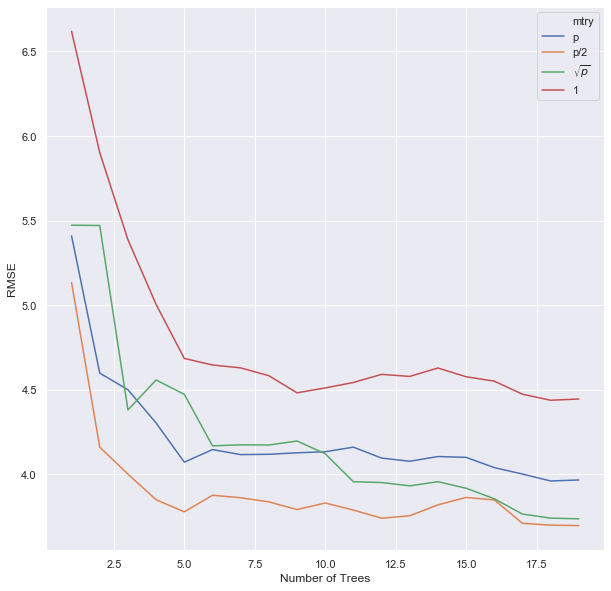

In [322]:
plt.figure(figsize=(10,10))
sns.lineplot(x='Number of Trees', y='RMSE', hue='mtry', 
             data=pd.DataFrame(results, columns=['Number of Trees', 'mtry', 'RMSE']))

print("The above shows the test RMSE for a 50% holdout set where training set contains 240 observations each with 14 predictors. \n We find that the test RMSE decreases with increasing number of trees for all values of mtry (number of random features considered at each split) \n The optimal value of m is less than p and greater than 1. In this case m=p‾√ yields the best results for ntree>? although p/2 performs better for some lower tree counts. \n Incredibly the model does not seem prone to overfitting with test RMSE continuing to decrees up to ntree = 100.")


# 8. In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable.

(a) Split the data set into a training set and a test set. 

(b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [547]:
car = pd.read_csv('Carseats_training.csv',index_col=0)
car.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
ID,,,,,,,,,,,
1,10.48,138,72,0,148,94,Medium,27,17,Yes,Yes
2,10.43,77,69,0,25,24,Medium,50,18,Yes,No
3,5.32,118,74,6,426,102,Medium,80,18,Yes,Yes
4,7.67,129,117,8,400,101,Bad,36,10,Yes,Yes
5,5.32,152,116,0,170,160,Medium,39,16,Yes,No


In [548]:
assert car.isnull().sum().sum() ==0
from sklearn import tree

In [549]:
X = car.drop('Sales',axis=1)
y= car['Sales']
Shelve = pd.get_dummies(X['ShelveLoc'])
Urban = pd.get_dummies(X['Urban'],drop_first=True)
US = pd.get_dummies(X['US'],drop_first=True)
X_new = pd.concat([X,Shelve,Urban,US],axis=1)
X_new = X_new.drop(['ShelveLoc','Urban','US'],axis=1)
X_new

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.8, random_state=42)

In [550]:
trees = tree.DecisionTreeRegressor(max_depth=5)
trees.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [551]:
pred = trees.predict(X_test)

In [552]:
rms = metrics.mean_squared_error(y_test,pred)
rmse = np.sqrt(rms)
print("MSE: {}".format(np.around(rmse,3)))

MSE: 2.578


In [553]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus

import graphviz 

    
dot_data = tree.export_graphviz(trees, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render('Tree')

'Tree.pdf'

# (c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

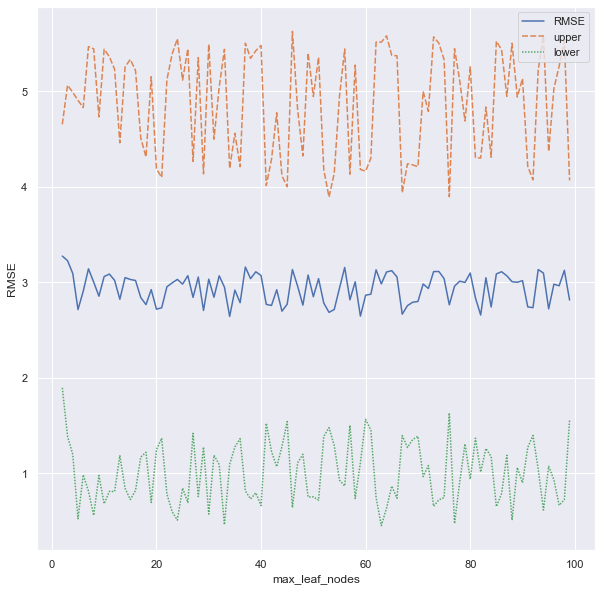

,RMSE,upper,lower
max_leaf_nodes,,,
34,2.641212,4.191036,1.091389


Test MSE: 5.836253991236144
Test RMSE: 2.4158340156633575


In [554]:
cv_folds = 10
tuning_param = 'max_leaf_nodes'
columns=[tuning_param, 'RMSE', 'upper', 'lower']
results = []

for i in range(2,100):
    regr = tree.DecisionTreeRegressor(max_leaf_nodes=i)
    scores = cross_val_score(regr,X_train,y_train,cv=cv_folds,scoring='neg_mean_squared_error')
    rmse = np.sqrt(np.absolute(scores))
    rm = np.mean(rmse)
    results += [[i,rm, rm+(2*np.std(rmse)), rm-(2*np.std(rmse))]]



#Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(data= results, columns=['max_leaf_nodes','RMSE','upper','lower']).set_index('max_leaf_nodes')
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('RMSE')
plt.show()

chosen = plot_df[plot_df['RMSE'] == plot_df['RMSE'].min()]
display(chosen)

# use chosen model to predict
optimalregr = tree.DecisionTreeRegressor(max_leaf_nodes=10).fit(X_train,y_train)
pred = optimalregr.predict(X_test)

print( "Test MSE: {}".format(metrics.mean_squared_error(y_test,pred)))
print("Test RMSE: {}".format(np.sqrt(metrics.mean_squared_error(y_test,pred))))



In [556]:
# use chosen model to predict
optimalregr = tree.DecisionTreeRegressor(max_leaf_nodes=10).fit(X_train,y_train)
pred = optimalregr.predict(X_test)

print( "Test MSE: {}".format(metrics.mean_squared_error(y_test,pred)))
print("Test RMSE: {}".format(np.sqrt(metrics.mean_squared_error(y_test,pred))))

Test MSE: 5.836253991236145
Test RMSE: 2.415834015663358


In [557]:
cartest = pd.read_csv('Carseats_testing.csv')
cartest.head()

,ID,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,1,107,111,14,400,103,Medium,41,11,No,Yes
1,2,147,58,7,100,191,Bad,27,15,Yes,Yes
2,3,115,89,0,38,122,Medium,25,12,Yes,No
3,4,122,76,0,270,100,Good,60,18,No,No
4,5,123,84,0,74,89,Good,59,10,Yes,No


In [558]:
ShelveLoc = pd.get_dummies(data = cartest['ShelveLoc'])
Urban = pd.get_dummies(cartest['Urban'],prefix='Urban',drop_first=True)
US = pd.get_dummies(cartest['US'],prefix='US',drop_first=True)
cartest.drop(['ShelveLoc','Urban','US'],axis=1,inplace=True)
cartest = pd.concat([cartest,ShelveLoc,Urban,US],axis=1)
cartest

,ID,CompPrice,Income,Advertising,Population,Price,Age,Education,Bad,Good,Medium,Urban_Yes,US_Yes
0,1,107,111,14,400,103,41,11,0,0,1,0,1
1,2,147,58,7,100,191,27,15,1,0,0,1,1
2,3,115,89,0,38,122,25,12,0,0,1,1,0
3,4,122,76,0,270,100,60,18,0,1,0,0,0
4,5,123,84,0,74,89,59,10,0,1,0,1,0
5,6,103,93,15,188,103,74,16,1,0,0,1,1
6,7,102,33,0,217,139,70,18,0,0,1,0,0
7,8,135,110,0,112,117,80,16,0,0,1,0,0
8,9,141,63,0,168,135,44,12,1,0,0,1,1
9,10,124,84,0,300,104,77,15,0,0,1,1,0


In [559]:
regr = tree.DecisionTreeRegressor(max_leaf_nodes=15).fit(X_train,y_train)
pred = regr.predict(X_test)
mse = metrics.mean_squared_error(y_test,pred)


In [560]:
print("Test MSE: {}".format(np.around(mse,3)))
print("Test RMSE: {}".format(np.around(np.sqrt(mse),3)))

Test MSE: 5.98
Test RMSE: 2.445


In [561]:
from sklearn.utils import resample
boot = resample(X_train, replace=True, n_samples=200, random_state=1)
bootstrap_test = resample(y_train,replace = True, n_samples=200,random_state=1)
X_train_new = pd.concat([boot,X_train])
y_train_new= pd.concat([bootstrap_test,y_train])

regr_new = tree.DecisionTreeRegressor(max_leaf_nodes=15).fit(X_train_new,y_train_new)
pred = regr_new.predict(X_test)
mse = metrics.mean_squared_error(y_test,pred)
print("Test MSE: {}".format(np.around(mse,3)))
print("Test RMSE: {}".format(np.around(np.sqrt(mse),3)))



Test MSE: 7.255
Test RMSE: 2.694


# (d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important.

In [562]:
# Bagging with 100 trees
# although I'm using RandomForestRegressor algo here this is Bagging because max_features = n_predictors

bagging = RandomForestRegressor(max_features=cartest.shape[1]-1,n_estimators = 100).fit(X_train,y_train)
pred = bagging.predict(X_test)

mse = metrics.mean_squared_error(y_test,pred)
rmse = np.sqrt(mse)

print("Test MSE: {}".format(np.around(mse,3)))
print("Test RMSE {}".format(np.around(rmse,3)))

Test MSE: 2.884
Test RMSE 1.698


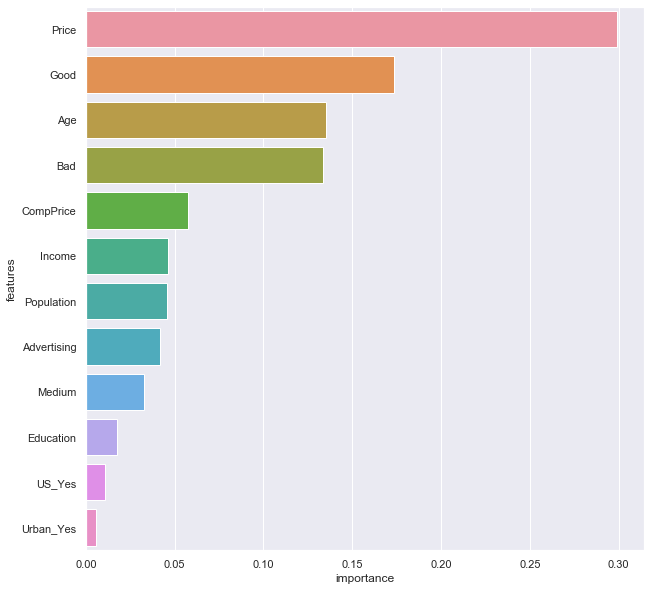

In [563]:
plot_df = pd.DataFrame({'features' : cartest.drop('ID',axis=1).columns,'importance': bagging.feature_importances_})

plt.figure(figsize = (10,10))
sns.barplot(x='importance',y='features',data = plot_df.sort_values('importance',ascending=False))

In [564]:
print("Bagging yields a significantly improved test MSE of 2.995 compared with 5.98 for the optimal pruned tree.\n\nThe bagging model indicates that instore Shelve Location (Good) and Price of the carseat are the most significant features affecting Sales revenue. This aligns with our observation when performing classification in hte lab.")


Bagging yields a significantly improved test MSE of 2.995 compared with 5.98 for the optimal pruned tree.

The bagging model indicates that instore Shelve Location (Good) and Price of the carseat are the most significant features affecting Sales revenue. This aligns with our observation when performing classification in hte lab.


# (e) Use random forests to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.¶

In [565]:
n_features = 4
n_trees = 100

rand = RandomForestRegressor(max_features=n_features,n_estimators=n_trees,random_state=101).fit(X_train,y_train)
pred = rand.predict(X_test)

mse = metrics.mean_squared_error(y_test,pred)

print("MSE: {}".format(np.around(mse,3)))
print("RMSE: {}".format(np.sqrt(np.around(mse,3))))

MSE: 2.841
RMSE: 1.6855266239368634


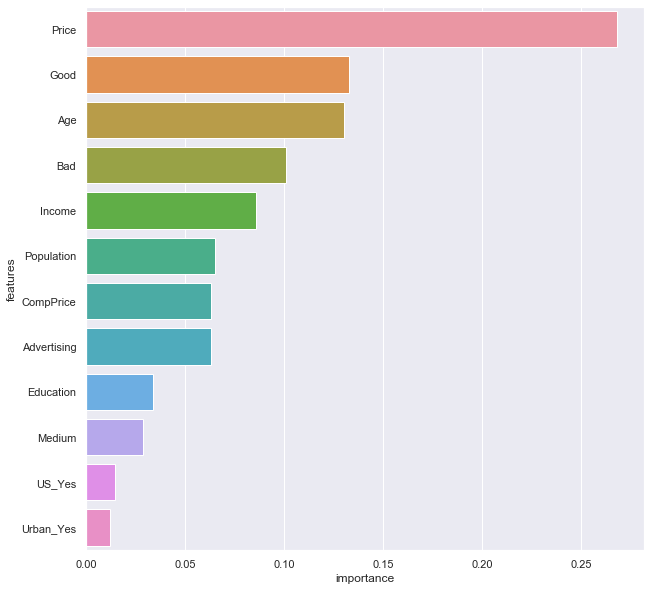

In [566]:
plot_df = pd.DataFrame({'features':cartest.drop('ID',axis=1).columns,'importance':rand.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance',y='features',data = plot_df.sort_values('importance',ascending= False))


In [567]:
rmse = []
m = []
for i in range(1,cartest.shape[1]):
    random = RandomForestRegressor(max_features=i,random_state=101,n_estimators=n_trees).fit(X_train,y_train)
    pred = random.predict(X_test)
    mse = metrics.mean_squared_error(y_test,pred)
    rmse_values = np.around(np.sqrt(mse),3)
    m.append(i)
    rmse.append(rmse_values)
    
    

,Splits,RMSE
3,4,1.685


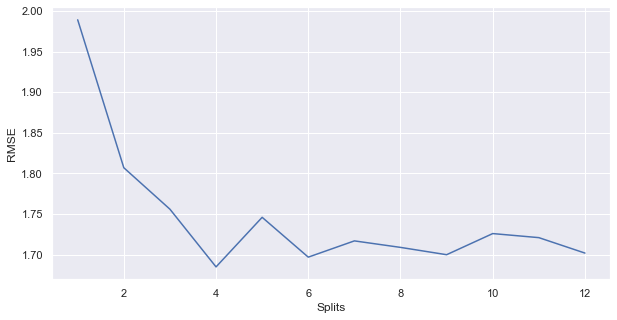

In [568]:
plt.figure(figsize=(10,5))
#sns.lineplot(x=m,y=rmse)
##plt.xlabel('Number of splits')
#plt.ylabel('RMSE')
p = pd.DataFrame({'Splits':m,'RMSE': rmse})
sns.lineplot(x='Splits',y='RMSE',data=p)

chose = p[p['RMSE']==p['RMSE'].min()]
display(chose)

# 9. This problem involves the OJ data set which is part of the ISLR package.
(a) Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [734]:
OrangeJuice = pd.read_csv('OJ.csv',index_col = 0)
OrangeJuice.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [735]:
train_set = OrangeJuice.sample(n=800,random_state=1)
train_set
array_Train = np.asarray([(i in train_set.index) for i in OrangeJuice.index])
test_set = OrangeJuice[~array_Train]

b) Fit a tree to the training data, with Purchase as the response and the other variables as predictors. Use the summary() function to produce summary statistics about the tree, and describe the results obtained. What is the training error rate? How many terminal nodes does the tree have?

In [736]:
y_train = train_set['Purchase']
X_train = train_set.drop(['Purchase','Store7','PctDiscMM','PctDiscCH'],axis=1)
y_test = test_set['Purchase']
X_test = test_set.drop(['Purchase','PctDiscMM','PctDiscCH','Store7'],axis=1)
#X_test = test_set.drop(['Store7','Purchase'],axis=1)


In [737]:
#corr = pd.DataFrame(data= X_train.corr(),columns=X_train.columns)
#corr[ corr.iloc[:,:]>= 0.8 ]    
#X_train.drop(['PctDiscMM','PctDiscCH'],axis=1,inplace=True)

In [714]:
#X_train.drop(['Store7'],axis=1) # Store7 always equals STORE == 0 

In [709]:
## all features 

cla_tree = tree.DecisionTreeClassifier(random_state=101).fit(X_train,y_train)
pred = cla_tree.predict(X_test)
print(metrics.classification_report(y_test,pred))


              precision    recall  f1-score   support

          CH       0.84      0.77      0.80       172
          MM       0.64      0.73      0.69        98

    accuracy                           0.76       270
   macro avg       0.74      0.75      0.74       270
weighted avg       0.77      0.76      0.76       270



In [747]:
# Fast Feature Selection

cla_tree = tree.DecisionTreeClassifier(random_state=101).fit(X_train,y_train)

score_trai = cla_tree.score(X_train,y_train)

print("Training error: {}".format(score_trai))

Training error: 0.99


(d) Create a plot of the tree, and interpret the results.

In [749]:
tree_ploted = tree.export_graphviz(cla_tree,out_file=None,
                                feature_names=X_train.columns, 
                                filled=True, rounded=True)
graph = graphviz.Source(tree_ploted) 
display(HTML(graph._repr_svg_()))

e) Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [752]:
pred = cla_tree.predict(X_test)
TP = metrics.confusion_matrix(y_test,pred)[0,0]
FP = metrics.confusion_matrix(y_test,pred)[0,1]
FN = metrics.confusion_matrix(y_test,pred)[1,0]
TN = metrics.confusion_matrix(y_test,pred)[1,1]
print(metrics.confusion_matrix(y_test,pred))
print("Test error rate: {}".format(np.around(1-(TP+TN)/(TP+TN+FP+FN),3)))


[[132  40]
 [ 26  72]]
Test error rate: 0.244


(f) Apply the cv.tree() function to the training set in order to determine the optimal tree size.

(g) Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.

(h) Which tree size corresponds to the lowest cross-validated classification error rate?

,Max Leaf Nodes,Accuracy
12,14.0,0.821167


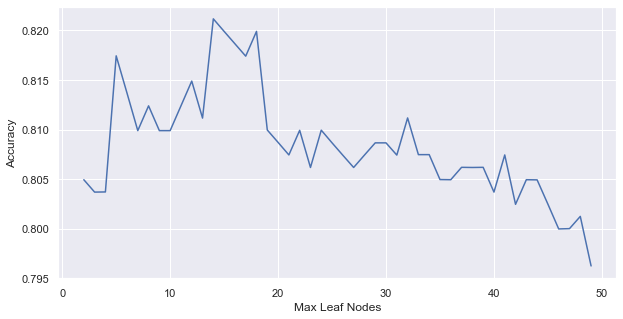

In [774]:
results = []
for i in range(2,50):
    Class_tree = tree.DecisionTreeClassifier(max_leaf_nodes=i)
    scores = cross_val_score(Class_tree,X_train,y_train,cv=10)
    results += [[i,np.mean(scores)]]

pd_result = pd.DataFrame(np.asarray(results),columns=['Max Leaf Nodes','Accuracy'])
plt.figure(figsize=(10,5))
sns.lineplot(x='Max Leaf Nodes',y='Accuracy',data=pd_result)


display(pd_result[pd_result['Accuracy']==pd_result['Accuracy'].max()])

,Train,Test
Max Leaf Nodes,,
2.0,0.8125,0.8
3.0,0.8125,0.8
27.0,0.8925,0.8


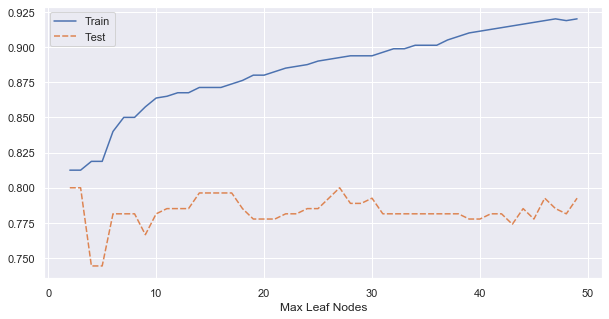

In [779]:
# Determine actual optimal tree size with test

results2 = []

for i in range(2,50):
    tree2 = tree.DecisionTreeClassifier(max_leaf_nodes=i).fit(X_train,y_train)
    
    train_score = tree2.score(X_train,y_train)
    test_score = tree2.score(X_test,y_test)
    results2 += [[i,train_score,test_score]]

pdresults = pd.DataFrame(np.asarray(results2),columns=['Max Leaf Nodes','Train','Test']).set_index('Max Leaf Nodes')
plt.figure(figsize = (10,5))
sns.lineplot(data = pdresults)

display(pdresults[pdresults['Test']==pdresults['Test'].max()])

(i) Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.

(j) Compare the training error rates between the pruned and unpruned trees. Which is higher?

(k) Compare the test error rates between the pruned and unpruned trees. Which is higher?

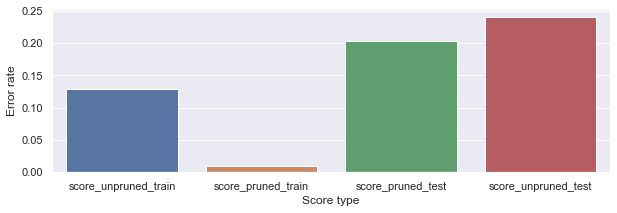

In [794]:
crss_tree_pruned = tree.DecisionTreeClassifier(max_leaf_nodes=14).fit(X_train,y_train)
crss_tree_unpruned = tree.DecisionTreeClassifier().fit(X_train,y_train)

score = [['score_unpruned_train',1 - crss_tree_pruned.score(X_train,y_train)],
         ['score_pruned_train',1- crss_tree_unpruned.score(X_train,y_train)],
         ['score_pruned_test',1-crss_tree_pruned.score(X_test,y_test)],
         ['score_unpruned_test',1-crss_tree_unpruned.score(X_test,y_test)]
        ]

plt.figure(figsize=(10,3))
results3 = pd.DataFrame(score,columns=['Score type','Error rate'])
sns.barplot(x='Score type',y='Error rate',data = results3)

In [795]:
results3

,Score type,Error rate
0,score_unpruned_train,0.128750
1,score_pruned_train,0.010000
2,score_pruned_test,0.203704
3,score_unpruned_test,0.240741


The unpruned tree performs best in the training setting whereas the pruned tree performs best in the test setting. This suggests that the unpruned tree is overfitting the training data leading to poor test score.

# 10. We now use boosting to predict Salary in the Hitters data set.
(a) Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [7]:
hitter = pd.read_csv('Hitters.csv')
hitter.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
AtBat,1.000000,0.967939,0.592198,0.913060,0.820539,0.669845,0.047372,0.235526,0.252717,0.236659,0.266534,0.244053,0.166123,0.317550,0.353824,0.352117,0.394771
Hits,0.967939,1.000000,0.562158,0.922187,0.811073,0.641211,0.044767,0.227565,0.255815,0.202712,0.261787,0.232005,0.151818,0.310673,0.320455,0.310038,0.438675
HmRun,0.592198,0.562158,1.000000,0.650988,0.855122,0.481014,0.116318,0.221882,0.220627,0.493227,0.262361,0.351979,0.233154,0.282923,-0.106329,0.039318,0.343028
Runs,0.913060,0.922187,0.650988,1.000000,0.798206,0.732213,0.004541,0.186497,0.204830,0.227913,0.250556,0.205976,0.182168,0.279347,0.220567,0.240475,0.419859
RBI,0.820539,0.811073,0.855122,0.798206,1.000000,0.615997,0.146168,0.294688,0.308201,0.441771,0.323285,0.393184,0.250914,0.343186,0.106591,0.193370,0.449457
Walks,0.669845,0.641211,0.481014,0.732213,0.615997,1.000000,0.136475,0.277175,0.280671,0.332473,0.338478,0.308631,0.424507,0.299515,0.149656,0.129382,0.443867
Years,0.047372,0.044767,0.116318,0.004541,0.146168,0.136475,1.000000,0.920289,0.903631,0.726872,0.882877,0.868812,0.838533,-0.004684,-0.080638,-0.162140,0.400657
CAtBat,0.235526,0.227565,0.221882,0.186497,0.294688,0.277175,0.920289,1.000000,0.995063,0.798836,0.983345,0.949219,0.906501,0.062283,0.002038,-0.066922,0.526135
CHits,0.252717,0.255815,0.220627,0.204830,0.308201,0.280671,0.903631,0.995063,1.000000,0.783306,0.984609,0.945141,0.890954,0.076547,-0.002523,-0.062756,0.548910
CHmRun,0.236659,0.202712,0.493227,0.227913,0.441771,0.332473,0.726872,0.798836,0.783306,1.000000,0.820243,0.929484,0.799983,0.112724,-0.158511,-0.138115,0.524931


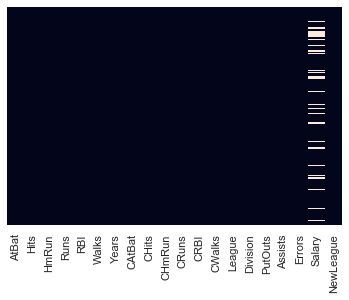

In [8]:
# check the null columns
sns.heatmap(hitter.isnull(),yticklabels=False,cbar=False)
# Alternative
hitter.isnull().sum()
hitter.corr()

In [9]:
hitter.dropna(inplace=True)

In [10]:
hitter.Salary= np.log(hitter.Salary)

In [11]:
hitter.Salary.describe()

count    263.000000
mean       5.927222
std        0.889192
min        4.212128
25%        5.247024
50%        6.052089
75%        6.620073
max        7.807917
Name: Salary, dtype: float64

# (b) Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations

In [16]:
League = pd.get_dummies(hitter['League'],prefix='League')
New_league = pd.get_dummies(hitter['NewLeague'],prefix='NewLeague')
Division = pd.get_dummies(hitter['Division'],prefix='Division')
hitters = pd.concat([hitter.drop(['NewLeague','League','Division'],axis=1),League,New_league,Division],axis=1)

#hitter = hitter.drop(['League','NewLeague','Division'],axis=1)

#train = np.random.choice(np.arange(len(hitters_df)), size=200, replace=False)
#Array_train = np.asarray([(i in train.index) for i in hitter.index])
#Array_train = np.asarray([(i in train) for i in hitter.index])
train = hitters.iloc[:200]
test = hitters.iloc[200:]
X_train = train.drop(['Salary'],axis=1)
y_train = train['Salary']
#test = hitter[~Array_train]
X_test = test.drop(['Salary'],axis=1)
y_test = test['Salary']
#X_train

# (c) Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter λ. Produce a plot with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis.

In [17]:
results = []

hitters
for learning_rate in np.logspace(-10, np.log(1.3), 100):
    boos = GradientBoostingRegressor(n_estimators=1000,learning_rate=learning_rate,random_state=1,max_features='auto')
    boos= boos.fit(X_train,y_train)
    pred_train = boos.predict(X_train)
    mse_train = metrics.mean_squared_error(y_train,pred_train)
    pred_test = boos.predict(X_test)
    mse_test = metrics.mean_squared_error(y_test,pred_test)
    results += [[learning_rate,mse_train,mse_test]]
    
plot = pd.DataFrame(data= np.asarray(results),columns=['Learning_rate','Mse_train','Mse_test']).set_index('Learning_rate')
    

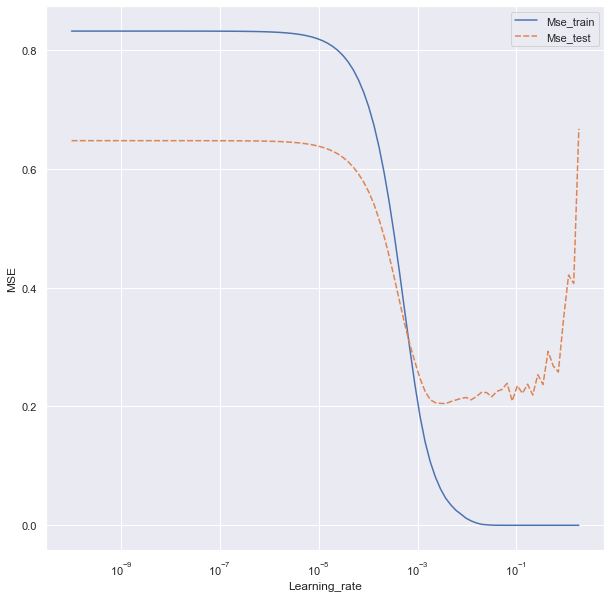

,Mse_train,Mse_test
Learning_rate,,
0.003691,0.045686,0.204795


In [18]:
plt.figure(figsize=(10,10))
ax  = sns.lineplot(data=plot)
ax.set_xscale('log')
plt.ylabel('MSE')
plt.show();

display(plot[plot['Mse_test'] == plot['Mse_test'].min()])

(f) Which variables appear to be the most important predictors in the boosted model?

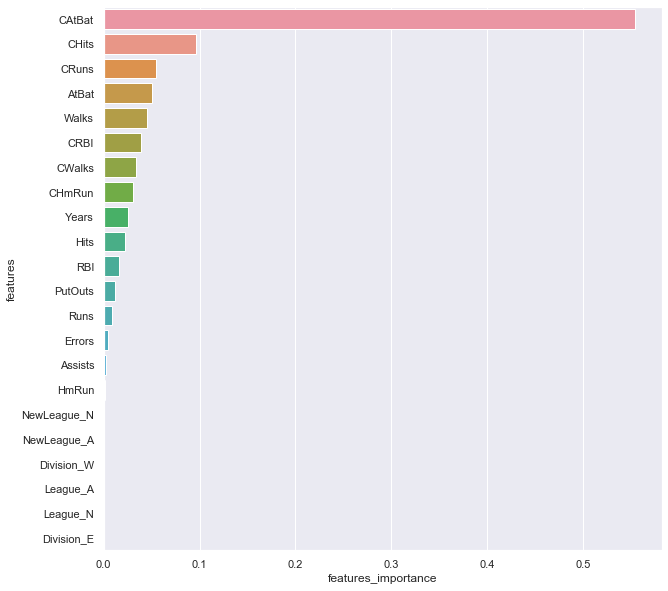

In [37]:
tree_count = 1000
learning_rate = 0.003691

regr = GradientBoostingRegressor(n_estimators=tree_count,
                                max_features= 'auto',
                                random_state = 1,
                                learning_rate=learning_rate).fit(X_train,y_train)
#hitters.columns
#len(regr.feature_importances_)

features = pd.DataFrame({'features': X_train.columns,'features_importance':regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='features_importance',y='features',data=features.sort_values('features_importance',ascending=False))

The boosting model suggests that CAtBat – Number of times at bat during his career – is by far the most important predictor of Salary.

Number of walks during his career (CWalks) is also predictive of salary, but it seems likely that this feature would be covariant with CAtBat.

(g) Now apply bagging to the training set. What is the test set MSE for this approach?

In [43]:
## Random Forest with max_features = n_predictors is a Bagging approach
bag = RandomForestRegressor(n_estimators = 1000,max_features=X_train.columns.size,random_state=101).fit(X_train,y_train)
bagpred = bag.predict(X_test)
mse = metrics.mean_squared_error(y_test,bagpred)
print("TEST MSE: {}".format(mse))

TEST MSE: 0.23336059556924255


Bagging achieves a test MSE of 0.208 which is equivalent to that achieved by boosting. Bagging has the advantage here that the result was achived without need to tune hyper-parameters.